In [1]:
import os
import time
import torch
import shutil
import random
import librosa
import functions
import torchaudio
import numpy as np
import pandas as pd
import torch.nn as nn
import soundfile as sf
from pesq import pesq
from pystoi import stoi
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader


In [2]:
daata, sr = torchaudio.load("./data/mixed/1.wav")
print(daata.shape, sr)

torch.Size([1, 130820]) 16000


### Data Import

In [3]:
def read_csv_data(filepath):
    df = pd.read_csv(filepath)
    return df

filepath = "./data_details.csv"
df = read_csv_data(filepath)
df = df.iloc[:2500]
print(df.shape)
df.head()

(2500, 17)


Unnamed: 0  mixed     near_end     far_end1     far_end2  \
0           0  1.wav  FAEM0_1.wav  MGJC0_4.wav  MJRK0_3.wav   
1           1  2.wav  FAEM0_1.wav  MMCC0_2.wav  MPRK0_1.wav   
2           2  3.wav  FAEM0_1.wav  FBAS0_4.wav  MSEM1_2.wav   
3           3  4.wav  FAEM0_1.wav  MTJG0_1.wav  MWAR0_3.wav   
4           4  5.wav  FAEM0_1.wav  FEEH0_3.wav  MRDS0_2.wav   

           mixed_path                near_end_path  \
0  ./data/mixed/1.wav  ./data/near_end/FAEM0_1.wav   
1  ./data/mixed/2.wav  ./data/near_end/FAEM0_1.wav   
2  ./data/mixed/3.wav  ./data/near_end/FAEM0_1.wav   
3  ./data/mixed/4.wav  ./data/near_end/FAEM0_1.wav   
4  ./data/mixed/5.wav  ./data/near_end/FAEM0_1.wav   

                far_end1_path               far_end2_path near_end_loc  \
0  ./data/far_end/MGJC0_4.wav  ./data/far_end/MJRK0_3.wav    [2, 4, 1]   
1  ./data/far_end/MMCC0_2.wav  ./data/far_end/MPRK0_1.wav    [9, 1, 3]   
2  ./data/far_end/FBAS0_4.wav  ./data/far_end/MSEM1_2.wav   [10, 2, 1]   
3  ./data/far_end/MTJG0_1.wav  ./data/far_end/MWAR0_3.wav    [9, 5, 3]   
4  ./data/far_end/FEEH0_3.wav  ./data/far_end/MRDS0_2.wav    [9, 4, 3]   

  far_end_loc1 far_end_loc2     mic_loc1     room_dim  sample_freq  \
0   [14, 7, 3]   [10, 1, 4]    [9, 7, 5]  [15, 10, 5]        16000   
1   [14, 5, 2]   [10, 5, 4]  [13, 10, 3]  [15, 10, 5]        16000   
2    [8, 6, 4]    [3, 2, 2]    [7, 5, 4]  [15, 10, 5]        16000   
3    [6, 3, 4]    [8, 9, 4]    [7, 6, 1]  [15, 10, 5]        16000   
4    [4, 7, 1]   [12, 2, 4]    [5, 1, 1]  [15, 10, 5]        16000   

   room_max_order  room_absorption  
0               3              0.2  
1               3              0.2  
2               3              0.2  
3               3              0.2  
4               3              0.2

In [4]:
mixed = df['mixed_path'].tolist()
far1 = df['far_end1_path'].tolist()
far2 = df['far_end2_path'].tolist()
near = df['near_end_path'].tolist()
print(len(near), len(far1), len(far2), len(mixed))

2500 2500 2500 2500


In [5]:
class WaveDataset(Dataset):
    def __init__(self, mixed, far1, far2, near, n_fft=512, hop_length=256, device='cuda', max_frames = 512):
        self.mixed = mixed
        self.far1 = far1
        self.far2 = far2
        self.near = near
        self.files = mixed
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.max_frames = max_frames
        self.device = device

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # read file -> stft -> abs of mag, remove phase -> return 4 values
        mixed_path = self.files[idx]
        far_path1 = self.far1[idx]
        far_path2 = self.far2[idx]
        near_path = self.near[idx]
        # print(mixed_path, far_path1, far_path2, near_path)
        
        mixed_wave, _ = torchaudio.load(mixed_path)
        far_wave1, _ = torchaudio.load(far_path1)
        far_wave2, _ = torchaudio.load(far_path2)
        near_wave, _ = torchaudio.load(near_path)
    
        mixed_stft = torch.stft(mixed_wave.squeeze(0), n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True, normalized=True)
        far_stft1 = torch.stft(far_wave1.squeeze(0), n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True, normalized=True)
        far_stft2 = torch.stft(far_wave2.squeeze(0), n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True, normalized=True)
        near_stft = torch.stft(near_wave.squeeze(0), n_fft=self.n_fft, hop_length=self.hop_length, return_complex=True, normalized=True)
    
        
        mixed_mag = torch.abs(mixed_stft)
        far_mag1 = torch.abs(far_stft1)
        far_mag2 = torch.abs(far_stft2)
        near_mag = torch.abs(near_stft)

        
        # print(mixed_mag.size(-1)) # max is 1023
        if mixed_mag.size(-1) < self.max_frames:
            padding = self.max_frames - mixed_mag.size(-1)
            mixed_mag = torch.nn.functional.pad(mixed_mag, (0, padding))
            far_mag1 = torch.nn.functional.pad(far_mag1, (0, padding))
            far_mag2 = torch.nn.functional.pad(far_mag2, (0, padding))
            near_mag = torch.nn.functional.pad(near_mag, (0, padding))
        elif mixed_mag.size(-1) > self.max_frames:
            mixed_mag = mixed_mag[:, :self.max_frames]
            far_mag1 = far_mag1[:, :self.max_frames]
            far_mag2 = far_mag2[:, :self.max_frames]
            near_mag = near_mag[:, :self.max_frames]

        
        return mixed_mag.to(self.device), far_mag1.to(self.device), far_mag2.to(self.device), near_mag.to(self.device), np.angle(near_stft)


## NSD

In [5]:
def get_mask(clean_signal, threshold=1e-6):
    if (type(clean_signal) == torch.Tensor):
        ideal_mask = torch.where(clean_signal >= threshold, torch.tensor(1.0), torch.tensor(0.0)).to(torch.float32) # for mask either 0 or 1
    else:
        ideal_mask = np.where(clean_signal >= threshold, 1.0, 0.0).astype(np.float32)
    return ideal_mask

In [32]:
class NearEndSpeechDetector(nn.Module):
    def __init__(self):
        super(NearEndSpeechDetector, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=771, out_channels=512, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )
        
        self.lstm1 = nn.LSTM(input_size=512, hidden_size=768, num_layers=2, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=768, hidden_size=257, num_layers=2, batch_first=True)
        
        self.fc = nn.Linear(512, 512)
    
    def forward(self, x):
        # Shape: (batch_size, n_frames, freq_bins) -> (batch_size, freq_bins, n_frames)
        cnn_output = self.conv_layer(x)
        cnn_output = cnn_output.permute(0, 2, 1)
        lstm1, _ = self.lstm1(cnn_output)
        lstm2, _ = self.lstm2(lstm1)
        lstm2 = lstm2.permute(0, 2, 1)
        nesd_output = self.fc(lstm2)  # shape [batch_size, 257, 512]
        output = torch.sigmoid(nesd_output)
        return output

In [7]:
batch_size = 128
num_epochs = 5
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_fft = 512
hop_length = n_fft//2
max_frames=512
train_dataset = WaveDataset(mixed, far1, far2, near, n_fft=n_fft, hop_length=hop_length, max_frames=max_frames)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = NearEndSpeechDetector().to(device)

In [8]:
def train_NSD(model, train_loader, num_epochs=10, learning_rate=0.001, device="cuda"):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0.0

        for mixed, far1, far2, near, near_phase in train_loader:
            combined_input = torch.cat((far1, far2, mixed), dim=1) # [batch_size, 257*3, 512]
            optimizer.zero_grad()

            outputs = model(combined_input)
            mask = get_mask(near).to(device)
            loss = criterion(outputs, mask)
            loss.backward()
            optimizer.step()
        
        duration = functions.timeit(start_time)
        print(f"[Epoch {epoch+1:3d}/{num_epochs:2d}] Train Loss: {loss.item():.4f}, Duration: {duration}")



In [9]:
train_NSD(model, train_loader, num_epochs=num_epochs, learning_rate=learning_rate)

[Epoch   1/10] Train Loss: 0.0017, Duration: 44 seconds
[Epoch   2/10] Train Loss: 0.0002, Duration: 48 seconds
[Epoch   3/10] Train Loss: 0.0002, Duration: 48 seconds
[Epoch   4/10] Train Loss: 0.0002, Duration: 44 seconds
[Epoch   5/10] Train Loss: 0.0002, Duration: 47 seconds
[Epoch   6/10] Train Loss: 0.0002, Duration: 45 seconds
[Epoch   7/10] Train Loss: 0.0002, Duration: 46 seconds
[Epoch   8/10] Train Loss: 0.0002, Duration: 45 seconds
[Epoch   9/10] Train Loss: 0.0002, Duration: 46 seconds
[Epoch  10/10] Train Loss: 0.0002, Duration: 45 seconds


In [10]:
torch.save(model, "./models/NSD_1.pth")

In [34]:
modelNSD = torch.load("./models/NSD_1.pth")
modelNSD = modelNSD.to('cuda') 
modelNSD.eval()


NearEndSpeechDetector(
  (conv_layer): Sequential(
    (0): Conv1d(771, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): ReLU()
  )
  (lstm): LSTM(512, 257, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=512, bias=True)
)

In [30]:
n_fft = 512
max_frames = 512
hop_length = n_fft//2
combined_in, near_mag, mixed_mag, far1_mag, far2_mag, phase = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav", n_fft=n_fft, hop_length=hop_length, max_frames=max_frames)
mask = get_mask(near_mag)

# NSD only
outputMask = model(combined_in.unsqueeze(0))
outputMask = outputMask.detach().cpu().squeeze(0).numpy()
output = mixed_mag.numpy() * outputMask
output_wave = functions.to_wave(output, phase, "./SampleFiles/output")
near_wave = functions.to_wave(near_mag.numpy(), phase)
erle_score = functions.compute_erle(near_wave, output_wave)
pesq_score = pesq(16000, near_wave, output_wave)
print(f"NSD only ERLE Score: {erle_score:.2f} dB")
print(f"NSD only PESQ Score: {pesq_score:.2f}")

NSD only ERLE Score: 8.81 dB
NSD only PESQ Score: 1.28


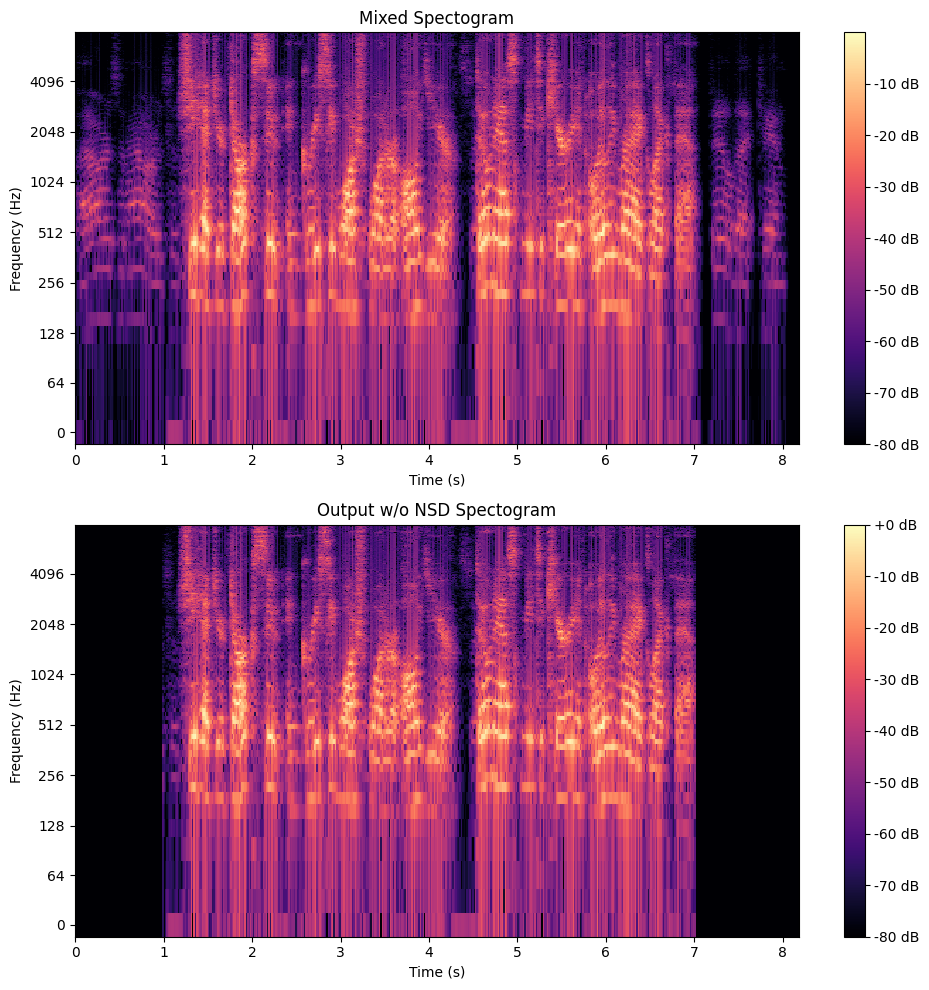

In [28]:
data = [mixed_mag, output]
titles = ["Mixed Spectogram", "NSD only Spectogram"]

functions.plot_spectograms(data, titles)

## UNET_NSD

In [5]:
class NearEndSpeechDetector(nn.Module):
    def __init__(self):
        super(NearEndSpeechDetector, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=771, out_channels=512, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )
        
        self.lstm1 = nn.LSTM(input_size=512, hidden_size=768, num_layers=2, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=768, hidden_size=257, num_layers=2, batch_first=True)
        
        self.fc = nn.Linear(512, 512)
    
    def forward(self, x):
        # Shape: (batch_size, n_frames, freq_bins) -> (batch_size, freq_bins, n_frames)
        cnn_output = self.conv_layer(x)
        cnn_output = cnn_output.permute(0, 2, 1)
        lstm1, _ = self.lstm1(cnn_output)
        lstm2, _ = self.lstm2(lstm1)
        lstm2 = lstm2.permute(0, 2, 1)
        nesd_output = self.fc(lstm2)  # shape [batch_size, 257, 512]
        output = torch.sigmoid(nesd_output)
        return output

def get_mask(clean_signal, threshold=1e-6):
    if (type(clean_signal) == torch.Tensor):
        ideal_mask = torch.where(clean_signal >= threshold, torch.tensor(1.0), torch.tensor(0.0)).to(torch.float32) # for mask either 0 or 1
    else:
        ideal_mask = np.where(clean_signal >= threshold, 1.0, 0.0).astype(np.float32)
    return ideal_mask

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, seq, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, seq)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [7]:
modelUNET = torch.load("./models/UNET_LSTM1_L1Loss.pth")
modelNSD = torch.load("./models/NSD_1.pth")
modelUNET = modelUNET.to('cuda') 
modelNSD = modelNSD.to('cuda') 
modelUNET.eval()
modelNSD.eval()


NearEndSpeechDetector(
  (conv_layer): Sequential(
    (0): Conv1d(771, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (lstm1): LSTM(512, 768, num_layers=2, batch_first=True)
  (lstm2): LSTM(768, 257, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=512, bias=True)
)

In [9]:
n_fft = 512
max_frames = 512
hop_length = n_fft//2
combined_in, near_mag, mixed_mag, far1_mag, far2_mag, phase, near_wave = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav", n_fft=n_fft, hop_length=hop_length, max_frames=max_frames)
mask = get_mask(near_mag)

# UNET only
outputUNET = modelUNET(combined_in.unsqueeze(0))
outputUNET = outputUNET.detach().cpu().squeeze(0).numpy()
outputUNET_wave = functions.to_wave(outputUNET, phase, filename="tempUNET", write=0)
erle_scoreUNET = functions.compute_erle(near_wave, outputUNET_wave)
pesq_scoreUNET = pesq(16000, near_wave, outputUNET_wave)

# UNET + NSD only
outputMask = modelNSD(combined_in.unsqueeze(0))
outputMask = outputMask.detach().cpu().squeeze(0).numpy()
outputMask = np.where(outputMask>0.1, 1, outputMask)
output = outputUNET * outputMask
output_wave = functions.to_wave(output, phase, filename="tempNSDUNET", write=0)
erle_score = functions.compute_erle(near_wave, output_wave)
pesq_score = pesq(16000, near_wave, output_wave)

print(f"UNET ERLE Score: {erle_scoreUNET:.2f} dB")
print(f"UNET PESQ Score: {pesq_scoreUNET:.2f}")
print(f"NSD+UNET ERLE Score: {erle_score:.2f} dB")
print(f"NSD+UNET PESQ Score: {pesq_score:.2f}")

UNET ERLE Score: 25.89 dB
UNET PESQ Score: 1.65
NSD+UNET ERLE Score: 25.89 dB
NSD+UNET PESQ Score: 1.65


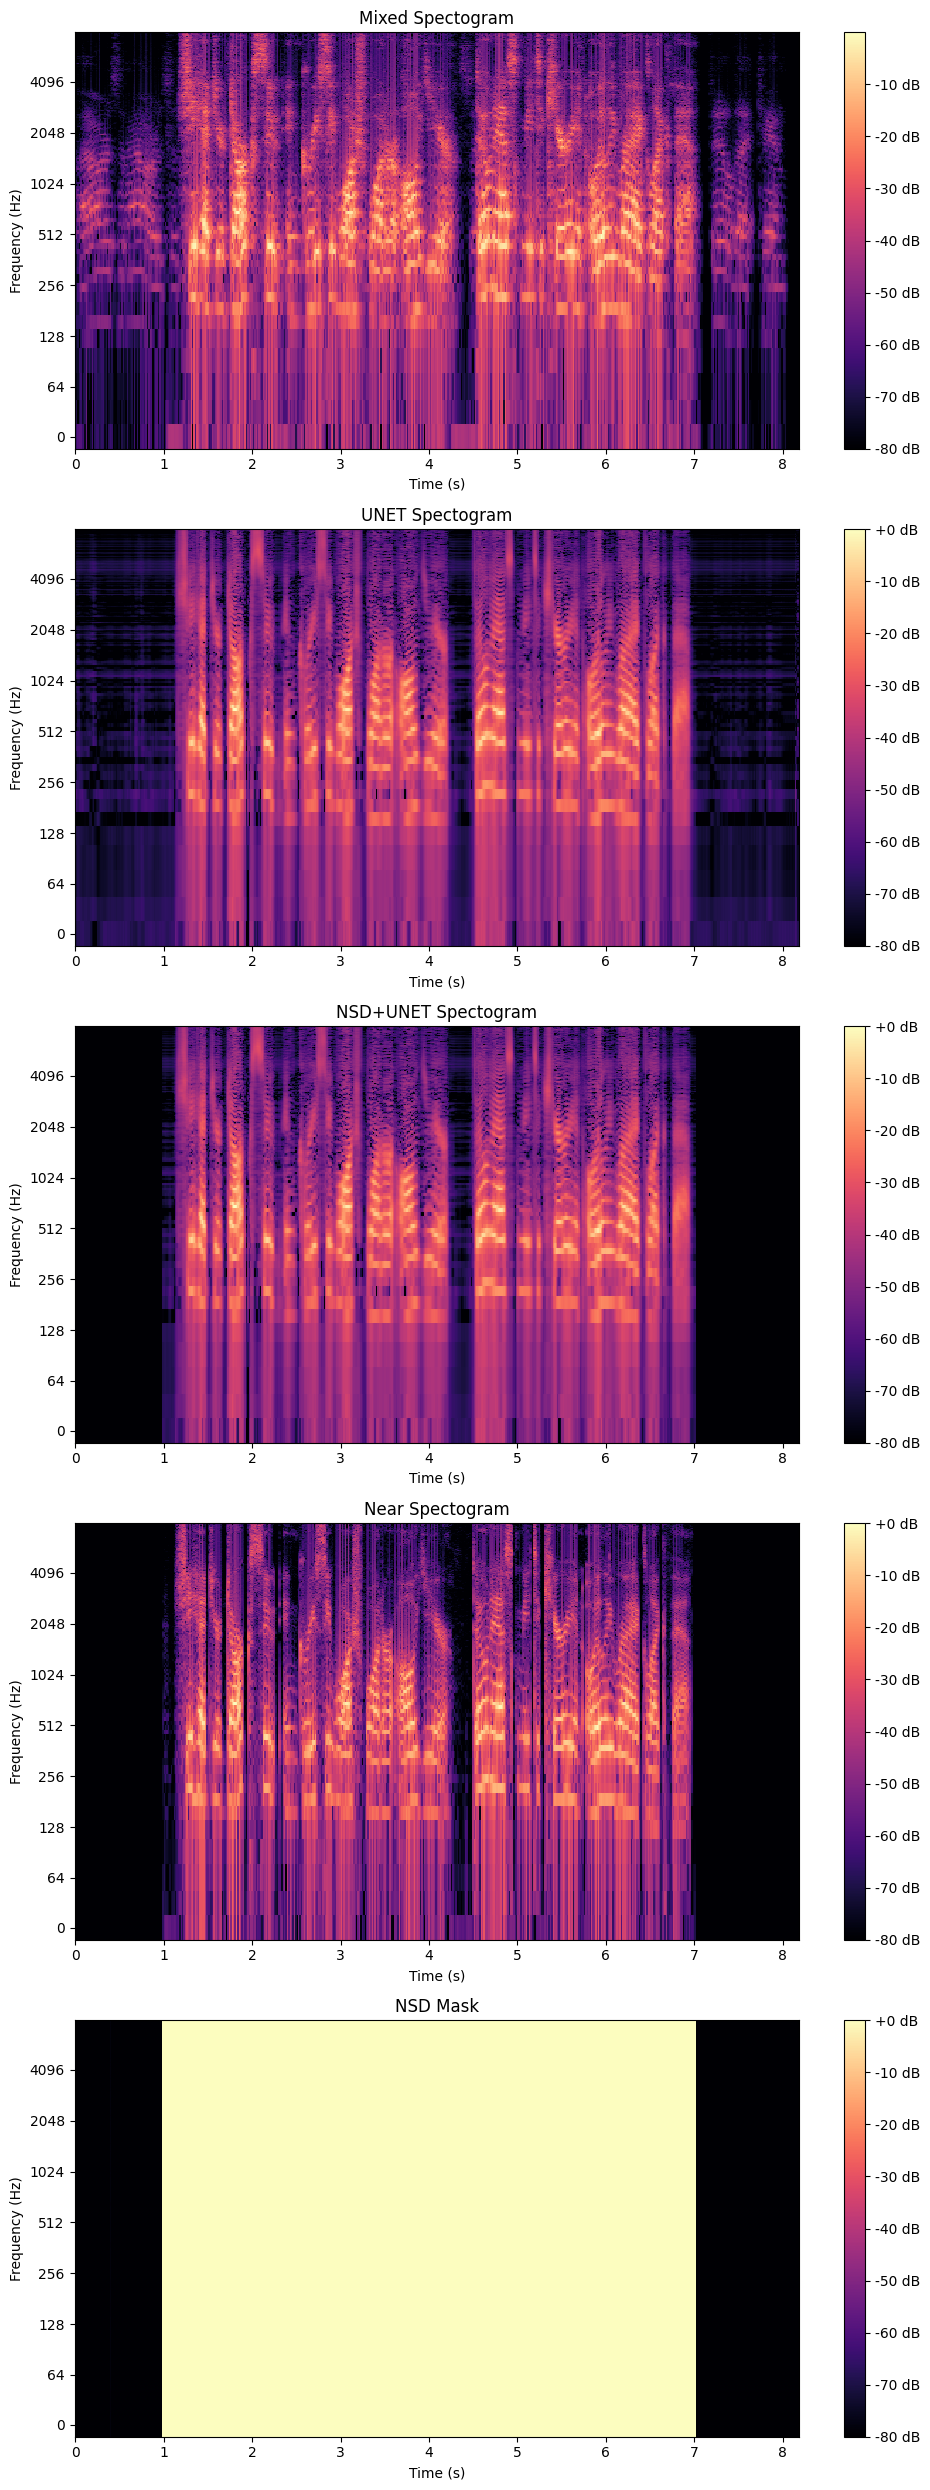

In [10]:
data = [mixed_mag, outputUNET, output, near_mag, outputMask]
titles = ["Mixed Spectogram", "UNET Spectogram", "NSD+UNET Spectogram", "Near Spectogram", "NSD Mask"]

functions.plot_spectograms(data, titles)

## ERLE in campus

In [67]:
import torchaudio
import functions

near_wave, sr = torchaudio.load("./SampleFiles/near.wav")
output_wave, sr = torchaudio.load("./SampleFiles/UNET_LSTM_1_L1Loss.wav")

print(near_wave.shape, output_wave.shape)

torch.Size([1, 130820]) torch.Size([1, 130816])


In [68]:
min_length = min(near_wave.shape[1], output_wave.shape[1])
near_wave = near_wave[:, :min_length]
output_wave = output_wave[:, :min_length]

output_wave = np.squeeze(output_wave.numpy())
near_wave = np.squeeze(near_wave.numpy())

functions.compute_erle(near_wave, output_wave)

25.893868504831143

In [34]:
files = ["CNN2D_1", "CNN1D_1", "CNN2D_4", "LSTM_1", "LSTM_2", "LSTM_3", "UNET_1", "UNET_2", "UNET_LSTM_1", "UNET_LSTM_2", "UNET_LSTM_3", "UNET_LSTM_1_L1Loss"]
base = "./SampleFiles/"
near_path = "./SampleFiles/near.wav"
for file in files:
    output_path = base + file +".wav"
    near_wave, _ = torchaudio.load(near_path)
    output_wave, _ = torchaudio.load(output_path)
    
    # Make sure they are same
    min_length = min(near_wave.shape[1], output_wave.shape[1])
    near_wave = near_wave[:, :min_length]
    output_wave = output_wave[:, :min_length]

    # reduce dimention
    output_wave = np.squeeze(output_wave.numpy())
    near_wave = np.squeeze(near_wave.numpy())

    erle = functions.compute_erle(near_wave, output_wave)
    print(f"{file:18s}", f"{erle:.2f}")

CNN2D_1            70.49
CNN1D_1            28.08
CNN2D_4            26.97
LSTM_1             29.43
LSTM_2             29.43
LSTM_3             29.43
UNET_1             25.52
UNET_2             25.64
UNET_LSTM_1        24.42
UNET_LSTM_2        38.32
UNET_LSTM_3        28.18
UNET_LSTM_1_L1Loss 25.89


In [62]:
output_wave.shape, temp_output_wave.shape, outputUNET_wave.shape

((130816,), (130816,), (130816,))

In [63]:
output_wave[:10], temp_output_wave[:10], outputUNET_wave[:10]

(array([ 0.0000000e+00,  3.0517578e-05,  0.0000000e+00, -3.0517578e-05,
         0.0000000e+00, -3.0517578e-05, -3.0517578e-05,  0.0000000e+00,
         0.0000000e+00, -3.0517578e-05], dtype=float32),
 array([ 1.1522464e-09,  2.3875792e-09,  8.2776563e-10, -2.5546242e-11,
         2.3125366e-10, -1.3215350e-09, -1.4008596e-10,  5.2209403e-10,
         4.6585517e-11, -3.4088032e-10], dtype=float32),
 array([ 2.01908060e-05,  4.32276393e-05,  1.50380820e-05, -1.18369265e-07,
         4.47699540e-06, -2.37102959e-05, -2.15749560e-06,  9.80410641e-06,
         4.31337270e-07, -6.63594574e-06], dtype=float32))

In [ ]:
first = 300

In [232]:
first = first+step
step = 5
last = first + step
near_wave[first:last], temp_near_wave[first:last]

(array([-0.00015259,  0.00030518,  0.00030518,  0.00015259,  0.        ],
       dtype=float32),
 array([-8.0835707e-06,  1.6280368e-05,  1.6396138e-05,  8.2572242e-06,
        -8.8471228e-13], dtype=float32))

In [234]:
functions.compute_erle(near_wave, temp_near_wave)

23.863022480278943

In [233]:
first, near_wave.shape

(17202, (130816,))

In [227]:
near_wave[first]

0.0

## Wavelet 

In [2]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import pywt
import soundfile as sf

#### NLMS Filter

In [23]:
def nlms_filter(input_audio, reference_audio, step_size=0.1, filter_length=256):
    """Applies NLMS adaptive filter."""
    input_audio = input_audio.numpy()
    reference_audio = reference_audio.numpy()
    filter_weights = np.zeros(filter_length)
    output_audio = np.zeros_like(input_audio)
    for i in range(len(input_audio)):
        if i >= filter_length:
            input_segment = input_audio[i - filter_length:i]
            predicted_echo = np.dot(filter_weights, input_segment[::-1])
            error = reference_audio[i] - predicted_echo
            power = np.dot(input_segment, input_segment) + 1e-6 # Avoid division by zero
            filter_weights += (step_size * error * input_segment[::-1]) / power
            output_audio[i] = error
        else:
            output_audio[i] = reference_audio[i] #initial samples are passed through.
    return torch.tensor(output_audio, dtype=torch.float)


In [70]:
def normalize_audio(audio):
    """Normalizes wave file using PyTorch."""
    mean = torch.mean(audio)
    std = torch.std(audio)
    normalized_audio = (audio - mean) / std
    return normalized_audio

In [77]:
mixed = "./SampleFiles/mixed.wav"
far1 = "./SampleFiles/far1.wav"
far2 = "./SampleFiles/far2.wav"
mixed, _ = torchaudio.load(mixed)
far1, _ = torchaudio.load(far1)
far2, _ = torchaudio.load(far2)
far = far1 + far2


In [78]:
far.shape, far1.shape, mixed.shape

(torch.Size([1, 130820]), torch.Size([1, 130820]), torch.Size([1, 130820]))

In [79]:
input_audio = normalize_audio(mixed)
reference_audio = normalize_audio(far)

nlms_output = nlms_filter(input_audio, reference_audio)

In [80]:
nlms_output.shape

torch.Size([1, 130820])

In [81]:
nlms_output_spect = torch.stft(nlms_output.squeeze(0), n_fft=512, hop_length=256, return_complex=True, normalized=True)
mixed_spect = torch.stft(mixed.squeeze(0), n_fft=512, hop_length=256, return_complex=True, normalized=True)
far_spect = torch.stft(far.squeeze(0), n_fft=512, hop_length=256, return_complex=True, normalized=True)

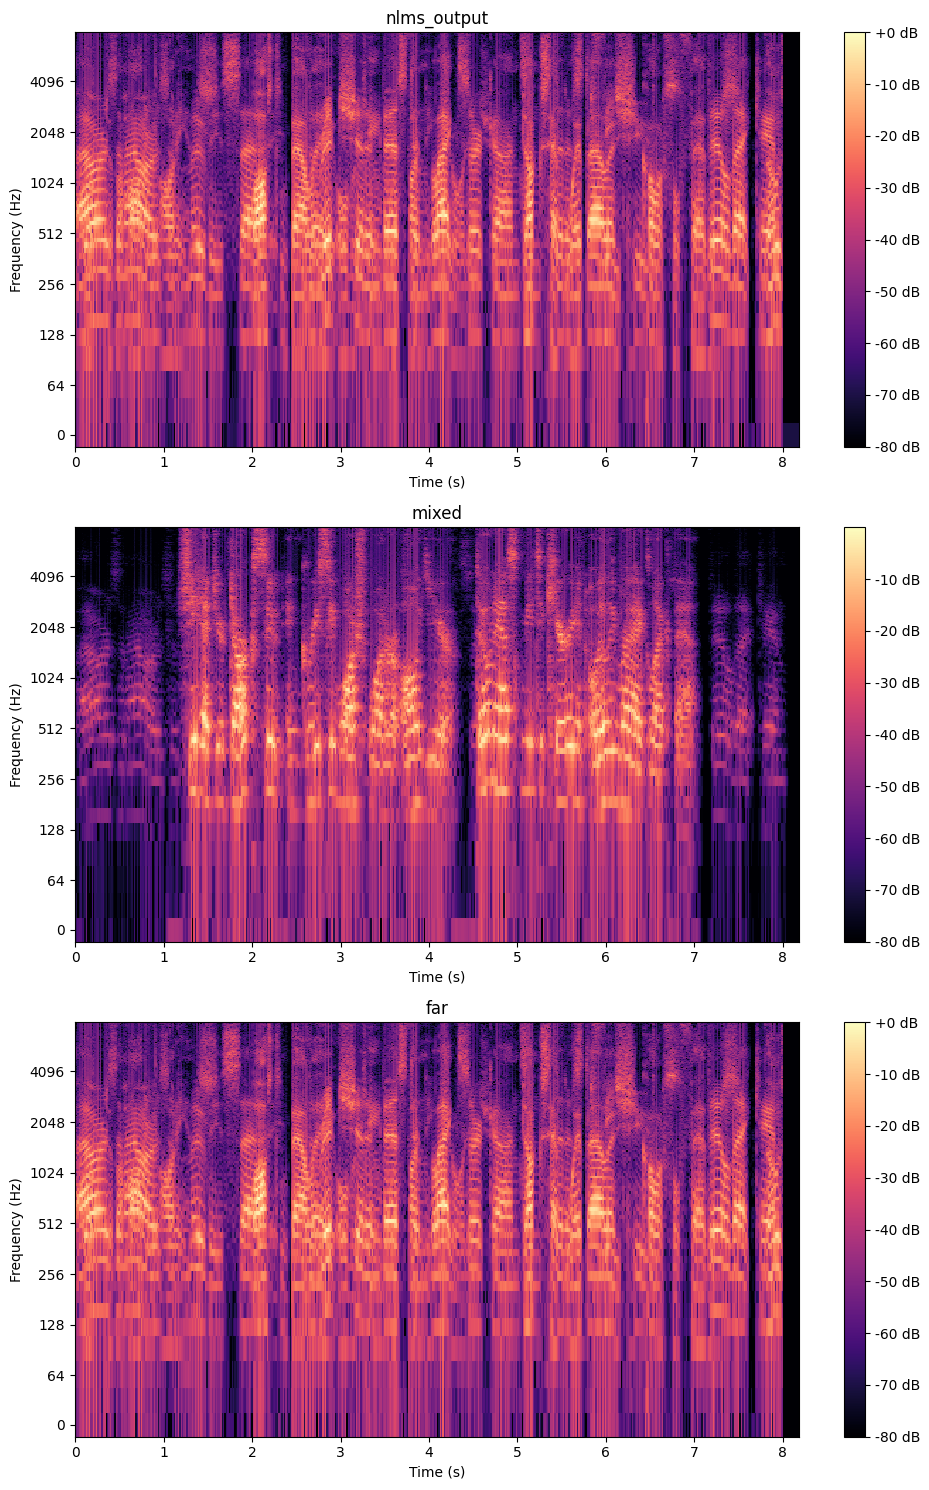

In [82]:
data = [nlms_output_spect, mixed_spect, far_spect]
titles = ["nlms_output", "mixed", "far"]
functions.plot_spectograms(data, titles)

#### Spectral Subtraction

In [15]:
def spectral_subtraction(waveform, sample_rate=16000, noise_profile_duration=1.0, smoothing_factor=0.8, over_subtraction=1.5):
    waveform = waveform.squeeze(0).numpy()
    n_fft = 512
    hop_length = n_fft // 2
    noise_frames = int(noise_profile_duration * sample_rate / hop_length)

    # Calculate STFT
    stft = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    magnitude_stft = np.abs(stft)
    phase_stft = np.angle(stft)

    # Estimate noise profile
    noise_magnitude = np.mean(magnitude_stft[:, :noise_frames], axis=1)

    # Apply spectral subtraction
    denoised_magnitude = np.maximum(magnitude_stft - over_subtraction * noise_magnitude[:, np.newaxis], 0)

    # Apply smoothing
    if smoothing_factor > 0:
        denoised_magnitude = smoothing_factor * denoised_magnitude + (1 - smoothing_factor) * magnitude_stft

    # Reconstruct signal
    denoised_stft = denoised_magnitude * np.exp(1j * phase_stft)
    denoised_waveform = librosa.istft(denoised_stft, hop_length=hop_length)

    return torch.from_numpy(denoised_waveform).unsqueeze(0), denoised_magnitude, magnitude_stft


In [16]:
mixed = "./SampleFiles/mixed.wav"
waveform, sr = torchaudio.load(mixed)
denoised_waveform, denoised_spectogram, noised_spectogram = spectral_subtraction(waveform, sr)
torchaudio.save("./SampleFiles/denoised_audio.wav", denoised_waveform, sr)

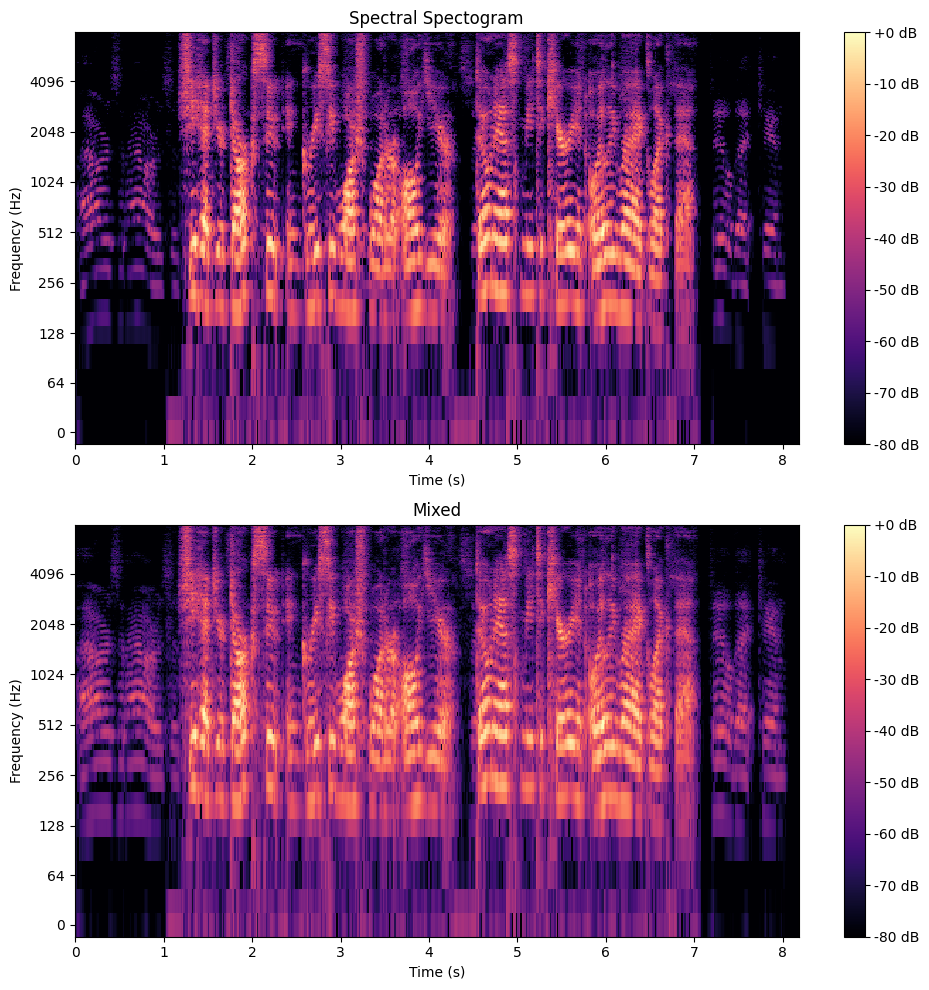

In [19]:
functions.plot_spectograms([denoised_spectogram, noised_spectogram], ["Spectral Spectogram", "Mixed"])

In [ ]:
erle_score = functions.compute_erle(denoised_spectogram, noised_spectogram)
pesq_score = pesq(16000, denoised_spectogram, noised_spectogram)

print(erle_score)
print(pesq_score)

#### UNET NSD and Spectral Subtraction

In [4]:
n_fft = 512
max_frames = 512
hop_length = n_fft//2
combined_in, near_mag, mixed_mag, far1_mag, far2_mag, phase, near_wave = functions.load_files("./data/mixed/1.wav", "./data/far_end/MGJC0_4.wav", "./data/far_end/MJRK0_3.wav", "./data/near_end/FAEM0_1.wav", n_fft=n_fft, hop_length=hop_length, max_frames=max_frames)


In [5]:
def spectral_subtraction(waveform, sample_rate=16000, noise_profile_duration=1.0, smoothing_factor=0.8, over_subtraction=1.5):
    waveform = waveform.squeeze(0).numpy()
    n_fft = 512
    hop_length = n_fft // 2
    noise_frames = int(noise_profile_duration * sample_rate / hop_length)

    # Calculate STFT
    stft = librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length)
    magnitude_stft = np.abs(stft)
    phase_stft = np.angle(stft)

    # Estimate noise profile
    noise_magnitude = np.mean(magnitude_stft[:, :noise_frames], axis=1)

    # Apply spectral subtraction
    denoised_magnitude = np.maximum(magnitude_stft - over_subtraction * noise_magnitude[:, np.newaxis], 0)

    # Apply smoothing
    if smoothing_factor > 0:
        denoised_magnitude = smoothing_factor * denoised_magnitude + (1 - smoothing_factor) * magnitude_stft

    # Reconstruct signal
    denoised_stft = denoised_magnitude * np.exp(1j * phase_stft)
    denoised_waveform = librosa.istft(denoised_stft, hop_length=hop_length)

    return torch.from_numpy(denoised_waveform).unsqueeze(0), denoised_magnitude, magnitude_stft


In [6]:
mixed = "./data/mixed/1.wav"
waveform, sr = torchaudio.load(mixed)
_, denoised_spectogram, _ = spectral_subtraction(waveform, sr)

In [7]:
denoised_spectogram.shape

(257, 512)

In [ ]:
functions.plot_spectograms([denoised_spectogram, noised_spectogram], ["Spectral Spectogram", "Mixed"])

In [8]:
class NearEndSpeechDetector(nn.Module):
    def __init__(self):
        super(NearEndSpeechDetector, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=771, out_channels=512, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Dropout(p=0.3),
        )
        
        self.lstm1 = nn.LSTM(input_size=512, hidden_size=768, num_layers=2, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=768, hidden_size=257, num_layers=2, batch_first=True)
        
        self.fc = nn.Linear(512, 512)
    
    def forward(self, x):
        # Shape: (batch_size, n_frames, freq_bins) -> (batch_size, freq_bins, n_frames)
        cnn_output = self.conv_layer(x)
        cnn_output = cnn_output.permute(0, 2, 1)
        lstm1, _ = self.lstm1(cnn_output)
        lstm2, _ = self.lstm2(lstm1)
        lstm2 = lstm2.permute(0, 2, 1)
        nesd_output = self.fc(lstm2)  # shape [batch_size, 257, 512]
        output = torch.sigmoid(nesd_output)
        return output

def get_mask(clean_signal, threshold=1e-6):
    if (type(clean_signal) == torch.Tensor):
        ideal_mask = torch.where(clean_signal >= threshold, torch.tensor(1.0), torch.tensor(0.0)).to(torch.float32) # for mask either 0 or 1
    else:
        ideal_mask = np.where(clean_signal >= threshold, 1.0, 0.0).astype(np.float32)
    return ideal_mask
mask = get_mask(near_mag)

In [9]:
class UNet(nn.Module):
    def __init__(self, in_channels=771, out_channels=257, features = [512, 768, 1024, 1280]):
        super(UNet, self).__init__()

        self.hidden_size=features[-1]*2
        
        # Encoder (Downsampling path)
        self.encoder_conv1 = self._double_conv(in_channels, features[0])
        self.encoder_pool1 = nn.MaxPool1d(2)
        self.encoder_conv2 = self._double_conv(features[0], features[1])
        self.encoder_pool2 = nn.MaxPool1d(2)
        self.encoder_conv3 = self._double_conv(features[1], features[2])
        self.encoder_pool3 = nn.MaxPool1d(2)
        self.encoder_conv4 = self._double_conv(features[2], features[3])
        self.encoder_pool4 = nn.MaxPool1d(2)

        # Bottleneck
        self.LSTM = nn.LSTM(features[3], self.hidden_size, num_layers=2, batch_first=True)

        # Decoder (Upsampling path)
        self.decoder_up4 = nn.ConvTranspose1d(features[3]*2, features[3], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv4 = self._double_conv(features[3]*2, features[2])
        self.decoder_up3 = nn.ConvTranspose1d(features[2], features[2], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv3 = self._double_conv(features[2]*2, features[1])
        self.decoder_up2 = nn.ConvTranspose1d(features[1], features[1], kernel_size=2, stride=2)
        self.decoder_conv2 = self._double_conv(features[1]*2, features[0])
        self.decoder_up1 = nn.ConvTranspose1d(features[0], features[0], kernel_size=2, stride=2, output_padding=0)
        self.decoder_conv1 = self._double_conv(features[0]*2, features[0])

        # Output layer
        self.output_conv = nn.Conv1d(features[0], out_channels, kernel_size=1)  # 1x1 convolution


    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        pool1 = self.encoder_pool1(enc1)
        enc2 = self.encoder_conv2(pool1)
        pool2 = self.encoder_pool2(enc2)
        enc3 = self.encoder_conv3(pool2)
        pool3 = self.encoder_pool3(enc3)
        enc4 = self.encoder_conv4(pool3)
        pool4 = self.encoder_pool4(enc4)
        
        # # Bottleneck
        pool4_T = pool4.transpose(1, 2) # (batch, seq, features)
        bottleneck = self.LSTM(pool4_T) # output is a tuple of format (output, (hidden state, cell state))
        bottleneck_T = bottleneck[0].transpose(1,2) # (batch, features, seq)
        
        # # Decoder with skip connections
        dec4 = self.decoder_up4(bottleneck_T)
        dec4 = self.decoder_conv4(torch.cat([dec4, enc4], dim=1))  # Concatenate skip connection
        dec3 = self.decoder_up3(dec4)
        dec3 = self.decoder_conv3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.decoder_up2(dec3)
        dec2 = self.decoder_conv2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.decoder_up1(dec2)
        dec1 = self.decoder_conv1(torch.cat([dec1, enc1], dim=1))

        # Output
        output = self.output_conv(dec1)
        return output

In [10]:
modelUNET = torch.load("./models/UNET_LSTM1_L1Loss.pth")
modelNSD = torch.load("./models/NSD_1.pth")
modelUNET = modelUNET.to('cuda') 
modelNSD = modelNSD.to('cuda') 
modelUNET.eval()
modelNSD.eval()


NearEndSpeechDetector(
  (conv_layer): Sequential(
    (0): Conv1d(771, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
  )
  (lstm1): LSTM(512, 768, num_layers=2, batch_first=True)
  (lstm2): LSTM(768, 257, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=512, bias=True)
)

In [11]:
far1_mag.shape

torch.Size([257, 512])

In [15]:
# UNET + NSD + Spectral Subtraction
model_input = torch.cat((far1_mag, far2_mag, torch.from_numpy(denoised_spectogram)), dim=0).unsqueeze(0).to('cuda')# get the spectral subtraction spectogram with far 1 and far 2
outputUNET1 = modelUNET(model_input)
outputUNET1 = outputUNET1.detach().cpu().squeeze(0).numpy()
outputMask1 = modelNSD(model_input)
outputMask1 = outputMask1.detach().cpu().squeeze(0).numpy()
outputMask1 = np.where(outputMask1>0.1, 1, outputMask1)
output1 = outputUNET1 * outputMask1
output_wave1 = functions.to_wave(output1, phase, filename="tempspectralUNET", write=0)
erle_score1 = functions.compute_erle(near_wave, output_wave1)
pesq_score1 = pesq(16000, near_wave, output_wave1)



# UNET + NSD only
outputUNET = modelUNET(combined_in.unsqueeze(0))
outputUNET = outputUNET.detach().cpu().squeeze(0).numpy()
outputMask = modelNSD(combined_in.unsqueeze(0))
outputMask = outputMask.detach().cpu().squeeze(0).numpy()
outputMask = np.where(outputMask>0.1, 1, outputMask)
output = outputUNET * outputMask
output_wave = functions.to_wave(output, phase, filename="tempNSDUNET", write=0)
erle_score = functions.compute_erle(near_wave, output_wave)
pesq_score = pesq(16000, near_wave, output_wave)

print(f"Spectral UNET ERLE Score: {erle_score1:.2f} dB")
print(f"Spectral UNET PESQ Score: {pesq_score1:.2f}")
print(f"NSD+UNET ERLE Score: {erle_score:.2f} dB")
print(f"NSD+UNET PESQ Score: {pesq_score:.2f}")

Spectral UNET ERLE Score: 18.28 dB
Spectral UNET PESQ Score: 1.11
NSD+UNET ERLE Score: 25.89 dB
NSD+UNET PESQ Score: 1.65


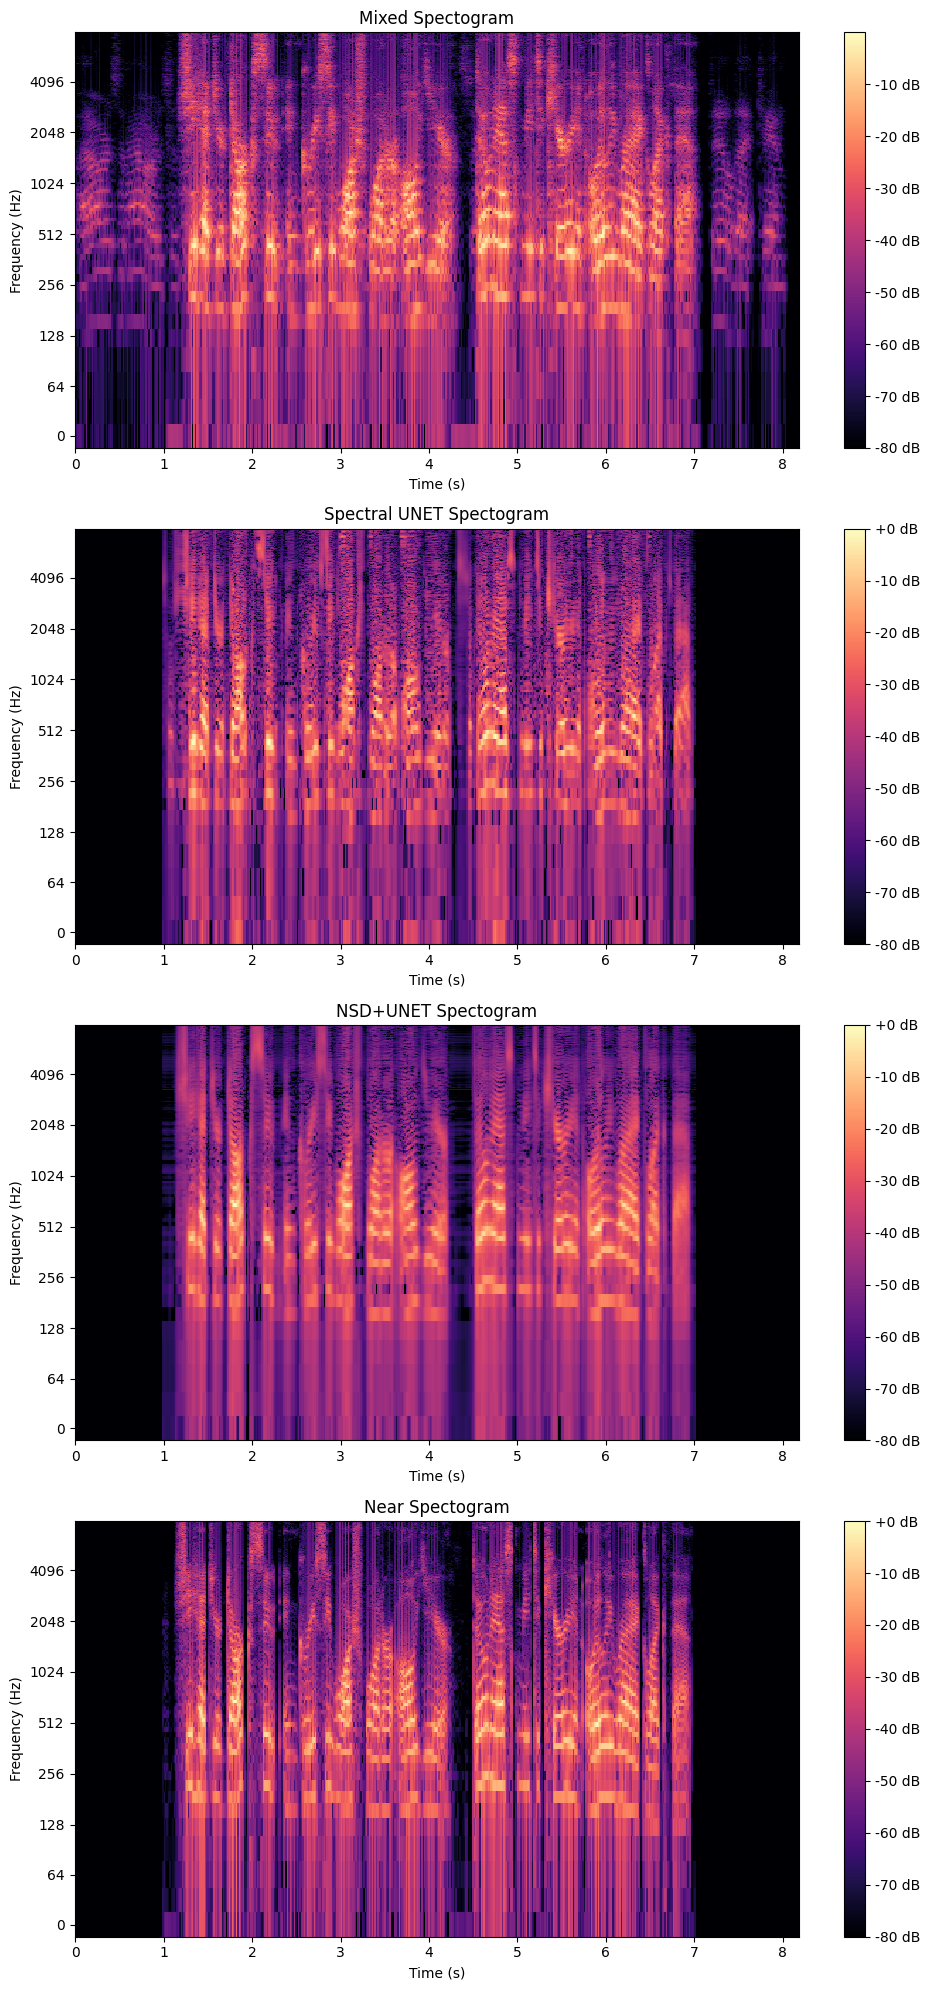

In [16]:
data = [mixed_mag, output1, output, near_mag]
titles = ["Mixed Spectogram", "Spectral UNET Spectogram", "NSD+UNET Spectogram", "Near Spectogram"]

functions.plot_spectograms(data, titles)